In [1]:
# ---------CASO D.1: Loop ideal V no cte y empuje cte -----------
import numpy as np
import pysindy as ps
from scipy.integrate import odeint, solve_ivp
#import eprint

import matplotlib.pyplot as plt
import math

import utils
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from mpl_toolkits.mplot3d import Axes3D

## Ecuaciones

- Para este caso se asume que la variación en la altura es tan pequeña que apenas produce cambio en la densidad
- Al tratarse de un loop ideal, el movimiento es simétrico en el plano vertical y se desarrollará con las alas a nivel
- Hay 3 ecuaciones (2 dinámicas y una angular) y 3 incógnitas (V, alpha y gamma)
$$
L - W\cos{\gamma} = mV\dot{\gamma}\\
\frac{1}{2} \rho_{aire} V^{2} S C_{L}-W\cos{\gamma} = mV\dot{\gamma}\\
---\\
T - D - W\sin{\gamma} = m\dot{V}\\
\frac{T}{m} - (C_{D0} + kC_{L}^2)\frac{1}{2} \rho_{aire} V^{2}\frac{S}{m} - g\sin{\gamma} = \dot{V}\\
---\\
\dot{\gamma} = \frac{V}{R}

$$

- Debido a la complejidad de este caso se usará las variables Cl, V y gamma. Alpha se considera en el cl porque si no hay demasiados términos y sindy no es capaz de calcularlo
- De nuevo, debido a la complejidad se elege un tiempo característico y una velocidad característica con las que adimensionalizar las ecuaciones
- Se define:

$$
\hat{V} = \frac{V}{U};\\
$$

Como son variables adimensionalizas (V y gamma) su derviada debe ser:
$$
\hat{\dot{V}} = \frac{\dot{V}T_c}{U};
\hat{\dot{\gamma}} = \dot{\gamma}T_c
$$

Se procede como en los casos anteriores y se adimensionaliza la velocidad:
$$
\frac{\hat{V}\hat{\dot{\gamma}}}{T_C} = \frac{1}{2}\rho \frac{S}{m}C_L U \hat{V}^2 - \frac{g\cos{\gamma}}{U} \\
\frac{\hat{\dot{V}}}{T_C} = \frac{T}{mU} - \frac{1}{2}\rho \frac{S}{m}(C_{D0} + k C_L^2) U \hat{V}^2 - \frac{g\sin{\gamma}}{U} \\
\frac{\hat{\dot{\gamma}}}{T_C} = \hat{V} \frac{U}{R} \\
---
$$
Se multiplican toas las ecuaciones por $T_C$

$$
\hat{V}\hat{\dot{\gamma}} = \frac{1}{2}\rho \frac{S}{m}C_L UT_C \hat{V}^2 - \frac{g\cos{\gamma}}{U}T_C \\
\hat{\dot{V}}= \frac{T}{mU}T_C - \frac{1}{2}\rho \frac{S}{m}(C_{D0} + k C_L^2) U T_C\hat{V}^2 - \frac{g\sin{\gamma}}{U}T_C \\
\hat{\dot{\gamma}} = \hat{V} \frac{U}{R}T_C \\

$$



Se asingan coeficientes:

$$
A_1 = \frac{1}{2}\rho\frac{S}{m}UT_C \\
A_2 = T_C\frac{g}{U} \\
A_3 = \frac{T}{mU}T_C \\
A_4 = T_C\frac{U}{R} \\
$$
Se eligen:
$$
T_c = \frac{U}{g} \\
U=\sqrt{\frac{2gm}{S\rho}}
$$ 
Los coeficientes quedarían:
$$
A_1 = 1; A_2 = 1; A_3 = \frac{T}{mg}; A_4 = \frac{2m}{\rho S R}
$$
Las ecuaciones:
$$
\hat{V}^2 C_L - \cos{\gamma} = \hat{V}\hat{\dot{\gamma}} \\
A_3 - (c_{D0} + kC_L^2) \hat{V}^2 - \sin{\gamma} = \hat{\dot{V}} \\
\hat{\dot{\gamma}} = A_4 \hat{V}
$$


Se sustituye la tercera ecuación en la primera y se despejando el $C_L$:
$$
C_L = \frac{\hat{V}\hat{\dot{\gamma}}}{\hat{V}^2} + \frac{\cos{\gamma}}{\hat{V}^2}
$$
Se sustituye el $C_L$ en la segunda ecuación, el sistema final que se obtiene es:
$$
A_3 - (cd_0 + kA_4^2)\hat{V}^2 - 2kA_4\cos{\gamma} - \sin{\gamma} - \frac{k(\cos{\gamma})^2}{\hat{V}^2} = \hat{\dot{V}} \\
\hat{\dot{\gamma}} = A_4 \hat{V}

Sindy debe obtener las siguientes ecuaciones:
$$
A_3 - A_5\hat{V}^2 - A_6\cos{\gamma} - A_7\sin{\gamma} - \frac{A_8(\cos{\gamma})^2}{\hat{V}^2} = \hat{\dot{V}} \\
\hat{\dot{\gamma}} = A_4 \hat{V}
$$
Donde:
$$
A_3 = \frac{T}{mg} \\
A_4 = \frac{2m}{\rho S R} \\
A_5 = cd_0 + kA_4^2 \\
A_6 = 2kA_4 \\
A_7 = 1 \\
A_8 = k \\

## Variables globales

In [2]:
#definición de las variables generales
n = 10000
deltat = 0.001
""" t = np.zeros(n+1)
for i in range(1, n+1):
    t[i] = deltat*i

print(t.shape[0], t) """
t = np.arange(0, int(n*deltat), deltat)

N_SIMS = 5

In [3]:
# definicion de parametros fisicos y aerondinamicos del cohete
m = 200
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073

T0 = 12 # T/m

R = 70
# velocidad caracteristica
U = (2*9.81*m/(1.225*S))**0.5
Tc = U/9.81
A1 = 0.5*1.225*U*Tc*S/m
A2 = Tc*9.81/U
A3 = T0*Tc/(U)
A4 = Tc*U/(R)
A5 = cd0 + k*A4**2
A6 = 2*k*A4
A7 = 1
A8 = k
print(f"Valor de los coeficientes: A1={A1}, A2={A2}, A3={A3}, A4={A4}, U={U}, Tc={Tc}")
print(f"Valores que sindy debe obtener: A3={A3}, A4={A4}, A5={A5}, A6={A6}, A7={A7}, A8={A8}")


Valor de los coeficientes: A1=0.9999999999999999, A2=1.0, A3=1.2232415902140672, A4=0.3173280974197259, U=14.76174801634704, Tc=1.5047653431546422
Valores que sindy debe obtener: A3=1.2232415902140672, A4=0.3173280974197259, A5=0.037350889863077684, A6=0.04632990222327998, A7=1, A8=0.073


In [4]:
def initial_vars(lib=utils.custom_ecs_D1()):   
    data = [np.ones((n, 2)), np.ones((n, 2))]
    print(data[0].shape, data[0].reshape(-1, 1).shape)
    lib = lib.fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['v', 'gamma'])
    print(list_names)
    return n_features, data, list_names

In [5]:
# creo un initial guess para que la primera solucion que encuentre no sea la de todas las ecuaciones = 0
#uso un reshape por el caso de tener un array, pues no tiene dimension de columnas, es posicional
def initial(val=10, lib=None):
    
    if lib is None:
        n_features, data, list_names = initial_vars(lib=utils.custom_ecs_D1())
        initial_guess = np.zeros((data[0].shape[1], n_features))
        """
        initial_guess[0, 0] = 1
        initial_guess[0, 1] =  0
        initial_guess[0, 2] =  0
        initial_guess[0, 3] = 1
        initial_guess[0, 4] = 32
        """

        initial_guess[0, list_names.index('1gamma')] = val
        initial_guess[0, list_names.index('v^2')] = val
        initial_guess[0, list_names.index('cos(gamma)^2/v^2')] = k*val
        initial_guess[0, list_names.index('cos(gamma)')] = val
        initial_guess[0, list_names.index('sin(gamma)')] = val

        initial_guess[1, list_names.index('v')] = val



        #print(data[0].reshape(-1, 1).shape[1], n_features)
        return initial_guess
    else:
        n_features, data, list_names = initial_vars(lib=lib)
        return np.ones((data[0].shape[1], n_features))
        

In [6]:
# uso de restricciones para el caso de librería personalizada
def restri(rhs=-A8*10):
    n_features, data, list_names = initial_vars()

    # Set constraints
    n_targets = data[1].shape[1]
    
    constraint_rhs = np.array([rhs]) #, -B/maxi[0]

    # One row per constraint, one column per coefficient
    constraint_lhs = np.zeros((1, n_targets * n_features))

    constraint_lhs[0, list_names.index('cos(gamma)^2/v^2')] = 1

    return constraint_lhs, constraint_rhs


## Funciones

In [7]:
def plot_ntraj(n_trayec, errors, 
            labs=['Nada', 'Con initial_guess', 'Con restristricciones', 'initial_guess + restricciones']):
    # lista errors: sin aplicar otro tipo de entrada, con cond inic, con restris y completo 
    fig, axs = plt.subplots(1, 2, figsize=(17, 9))
    fig.suptitle("Análisis sobre el número de trayectorias", fontsize=18)
    errors_mean = []
    for err in errors:    
        errors_mean.append(np.mean(err, axis=2))
   
    name = ['Velocidad (m/s)', 'Ángulo de asiento de la velocidad (rad)']
    
    for j, err in enumerate(errors_mean):
        for i in range(err.shape[-1]): 
            axs[i].set_title(name[i], fontsize=16)
            axs[i].semilogy(n_trayec, np.median(err[:, :, i], axis=0), label=labs[j])
            axs[i].set_xlabel('Número de trayectorias', fontsize=16)
            axs[i].set_ylabel('Error cuadrático medio', fontsize=16)
            axs[i].legend(fontsize=12)
            axs[i].tick_params(axis='both', labelsize=14)
        

In [8]:
def plot_error_vs_tiempo(t, errors, trayecs, labs=['nada', 'initial_guess', 'restris', 'completo']):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    name = ['vel (m/s)', 'gamma (rad)']

    for z, err in enumerate(errors):
        for j in range(err.shape[-1]): 
            axs[j].title.set_text(name[j])
            axs[j].set_xlabel('Tiempo (s)')
            axs[j].set_ylabel('Mediana del error')
            print(err.shape)
            err_simp = err[:, :, :, j]
            for i, n in enumerate(trayecs):
                lab = str(n) + ' trayec' + labs[z]
                axs[j].plot(t, np.median(err_simp[:, i], axis=0), label=lab)
            axs[j].legend()

In [9]:
def plot_error_vs_tiempo_val(t, errors, n_trayec, 
        labs=['nada', 'con initial_guess', 'con restristricciones', 'initial_guess + restricciones']):
    fig, axs = plt.subplots(1, 2, figsize=(15, 9))
    name = ['Velocidad (m/s)', 'Ángulo de asiento de la velocidad (rad)']
    fig.suptitle("Análisis sobre tiempos de validación mayores", fontsize=18)
    for z, err in enumerate(errors):
        for j in range(err.shape[-1]): 
            axs[j].set_title(name[j], fontsize=16)
            axs[j].set_xlabel('Tiempo de validacion(s)', fontsize=16)
            axs[j].set_ylabel('Mediana del error', fontsize=16)
            
            err_simp = err[:, :, :, j]
            for i, n in enumerate(n_trayec):
                lab = str(n) + ' trayec+' + labs[z]
                axs[j].semilogy(t, np.median(err_simp[:, i], axis=0), label=lab)
            axs[j].legend(fontsize=12)
            axs[j].tick_params(axis='both', labelsize=14)

In [10]:
def plot_error_vs_pot_ruido(error, n_trayec, pots):
    name = ['vel (m/s)', 'gamma (rad)']
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle("Evolución error según pot ruido", fontsize=14)

    for j in range(error.shape[-1]): 
        axs[j].title.set_text(name[j])
        axs[j].set_xlabel('Pot ruido')
        axs[j].set_ylabel('Mediana del error')
           
        err_simp = error[:, :, :, j]
        for i, n in enumerate(n_trayec):
            lab = str(n) + ' trayec' 
            axs[j].plt.semilogx(pots, np.median(err_simp[:, i], axis=0), label=lab)
            axs[j].legend()

In [11]:
def plot_precision_tiempo(error, muestras, tiempos):
    name = ['vel (m/s)', 'gamma (rad)']
    #fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    T, M = np.meshgrid(tiempos, muestras)
    
    for j in range(error.shape[-1]): 
        fig, axs = plt.subplots(figsize=(15, 7))
        ax = Axes3D(fig)
        ax.title.set_text(name[j])
        ax.set_xlabel('Tiempo máximo de entrenamiento')
        ax.set_ylabel('Número de muestras')
        ax.set_zlabel('Error cuadrático medio')
        ax.plot_surface(T, M, np.median(error[:, :, :, j], axis=0), cmap="coolwarm")
        ax.legend()

    

## Evaluación

In [16]:

n_trayectorias_test = [2, 10, 15, 20]
n_sims =  3
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = 0.0001
n2 = 10**6
t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]
#assert n2 == len_traj

constraint_lhs, constraint_rhs = restri()
models = [utils.Model_params(deltat=deltat_train, lib=utils.custom_ecs_D1(), opt=1,
            feature_list=['v', 'gamma'])]
errors = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2)) #escalado en el tiempo

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2))
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, n_trayectorias_test[i], 
                                        np.arange(0, int(n*deltat), deltat), 
                                        [A3, A4, cd0, k], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod, print_model=False)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
        if n_trayectorias_test[i] == 10 and mod_index ==0:
            #mod_class.plot_trayec(t_val)
            model10 = mod_class.model_sindy
         
    errors.append(error)

model10.print(lhs=['v', 'gamma'])

(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
v = -0.374 v^2 + -10.005 sin(gamma) + -0.448 cos(gamma) + -4.865 cos(gamma)^2/v^2 + 6.176 1v + 6.176 1gamma
gamma = 3.175 v


In [15]:
labs=['nada', 'initial_guess', 'restris', 'completo']

n_trayectorias_test = [2, 10, 15, 20]
n_sims =  3
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = 0.0001
n2 = 10**6
t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]
#assert n2 == len_traj

constraint_lhs, constraint_rhs = restri()
models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1),
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            lib=utils.custom_ecs_D1(), opt=1), 
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1)]
errors = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2)) #escalado en el tiempo

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2))
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, n_trayectorias_test[i], 
                                        np.arange(0, int(n*deltat), deltat), 
                                        [A3, A4, cd0, k], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod, print_model=False)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
        if n_trayectorias_test[i] == 10 and mod_index ==0:
            mod_class.plot_trayec(t_val)
         
    errors.append(error)


(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
nada
initial_guess
restris
completo
v = -0.374 x0^2 + -10.007 sin(x1) + -0.454 cos(x1) + -6.069 cos(x1)^2/x0^2 + 6.188 1x0 + 6.188 1x1
gamma = 3.176 x0


(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(x0)' = 0.1138 sin(x1) + -1.9420 1x0 + -1.9420 1x1
(x1)' = 0.3174 x0
(x0)' = -1.5738 sin(x1) + -1.9766 1x0 + -1.9766 1x1
(x1)' = 0.3175 x0
(x0)' = 1.6010 sin(x1) + -4.5092 1x0 + -4.5092 1x1
(x1)' = 0.3176 x0
(x0)' = -1.9544 sin(x1) + -3.4962 1x0 + -3.4962 1x1
(x1)' = 0.3176 x0
(x0)' = -1.3857 sin(x1) + -2.5689 1x0 + -2.5689 1x1
(x1)' = 0.3175 x0
(x0)' = -0.9170 sin(x1) + -2.9220 1x0 + -2.9220 1x1
(x1)' = 0.3175 x0
(x0)' = -0.7962 sin(x1) + -2.9358 1x0 + -2.9358 1x1
(x1)' = 0.3175 x0
(x0)' = -0.6230 sin(x1) + -2.9944 1x0 + -2.9944 1x1
(x1)' = 0.3175 x0
(x0)' = -0.4064 sin(x1) +

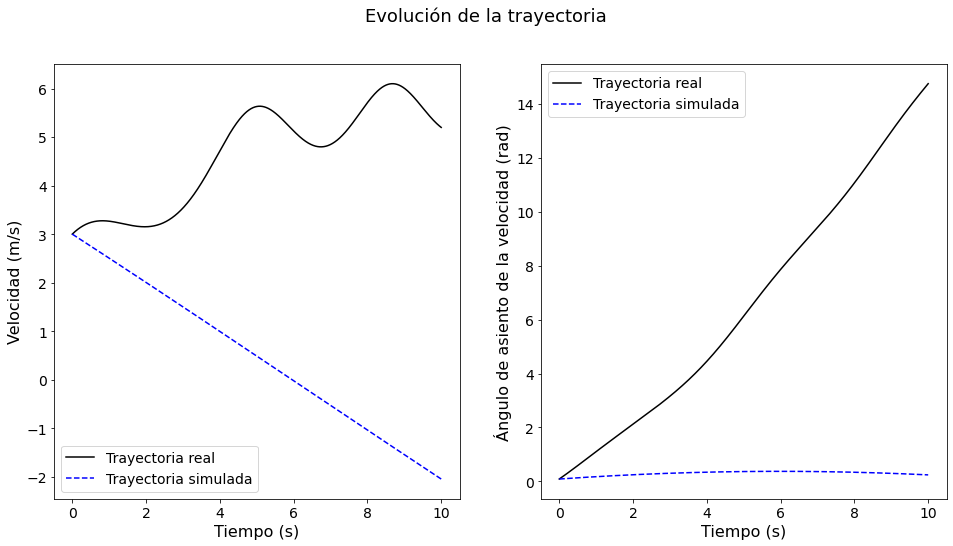

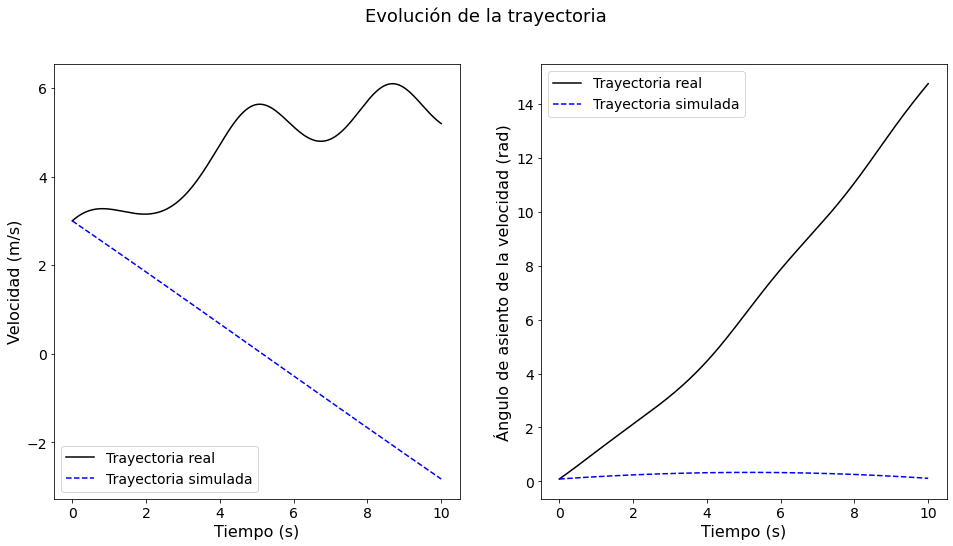

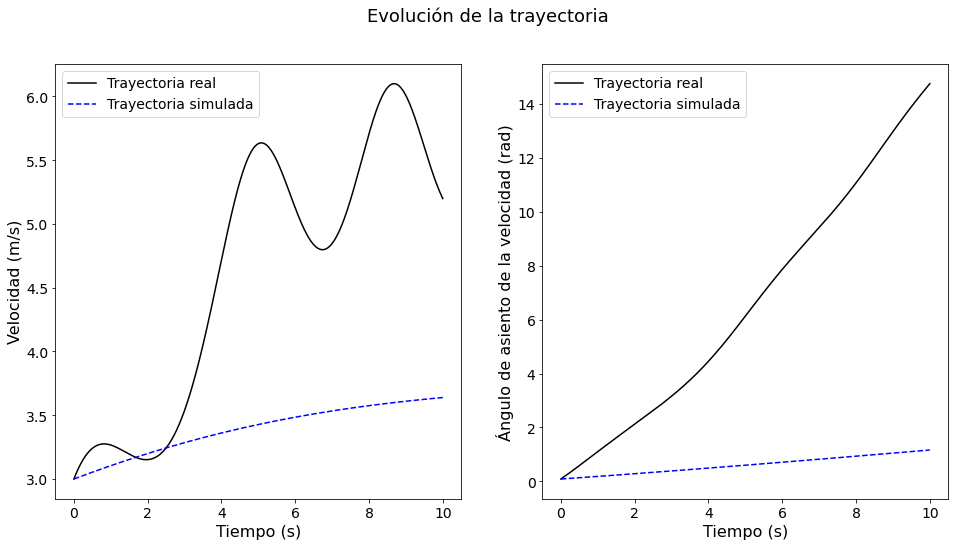

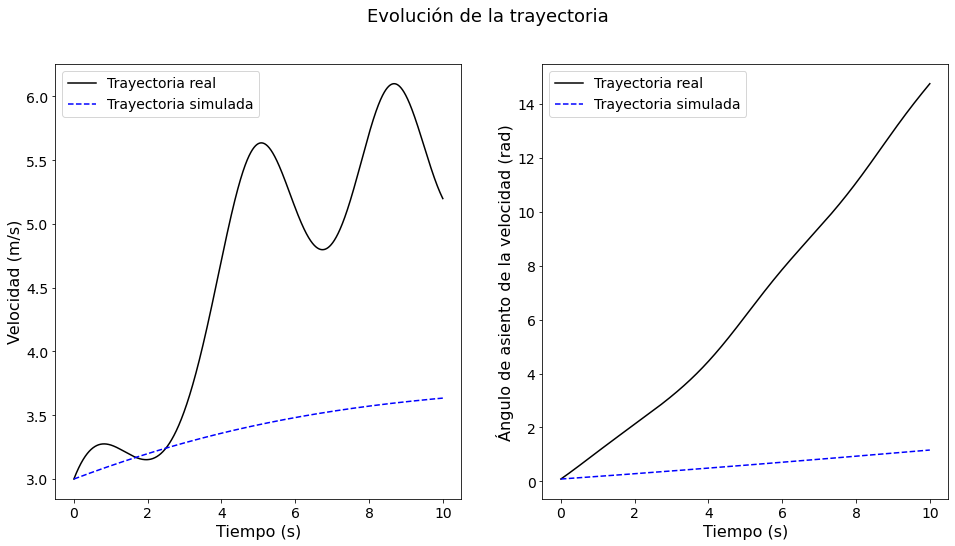

In [12]:
n_trayectorias_test = [2, 10, 15, 20]
n_sims = N_SIMS
len_traj = t.shape[0]
x0 = [3, 5] #v0 y gamma0 en rad, de validacionn

constraint_lhs, constraint_rhs = restri(rhs=-A8)
models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(val=1), lib=utils.custom_ecs_D1(), opt=1),
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            lib=utils.custom_ecs_D1(), opt=1), 
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            initial_guess=initial(val=1), lib=utils.custom_ecs_D1(), opt=1)]

error2 = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2)) #sin escalar
errors2 = []

for mod in models:
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, n_trayectorias_test[i], t, [A3, A4, cd0, k], x0, adim=False, mod=mod, 
                            print_model=True)
            error2[j,i, :, :] = mod_class.error_trayec(np.arange(0, int(n*deltat_train), deltat_train))
    mod_class.plot_trayec(t)
    errors2.append(error2)

(3, 4, 2)
(3, 4, 2)
(3, 4, 2)
(3, 4, 2)
(5, 4, 2)
(5, 4, 2)
(5, 4, 2)
(5, 4, 2)


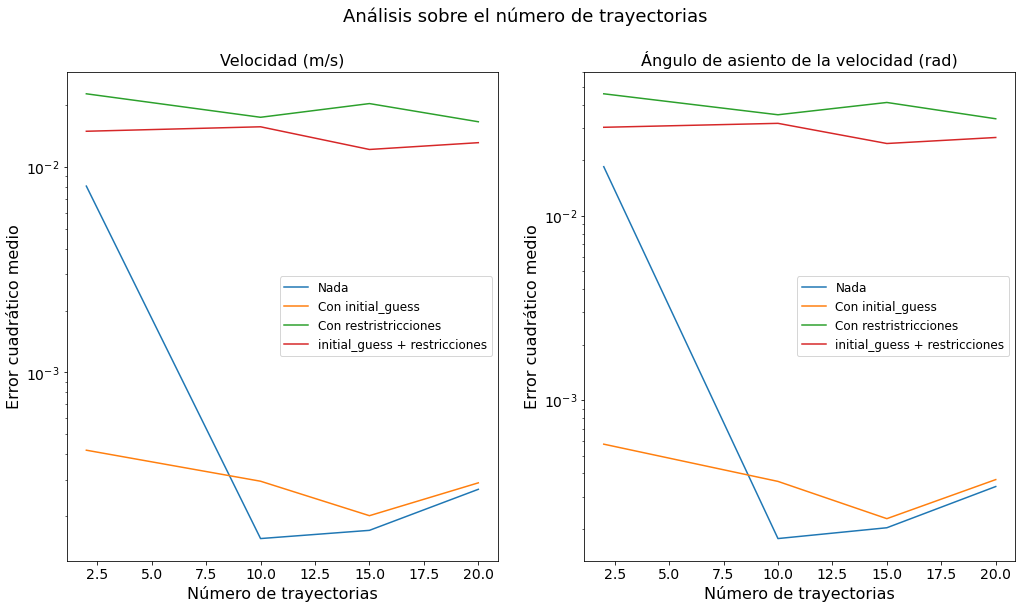

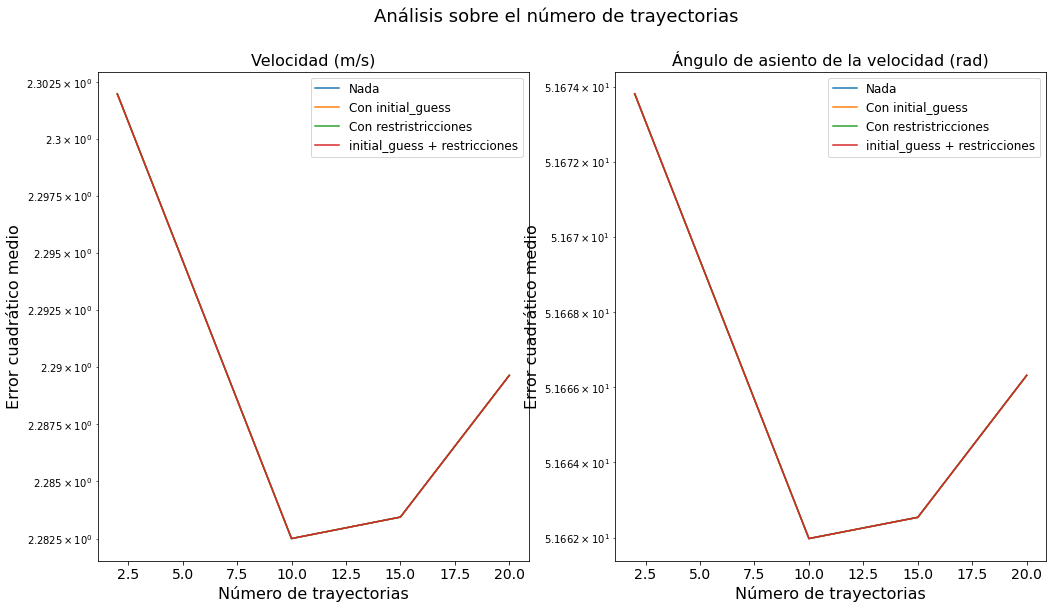

In [13]:
# Representa
plot_ntraj(n_trayectorias_test, errors) #escalado de tiempo
plot_ntraj(n_trayectorias_test, errors2) # sin escalar

In [32]:
# error vs tiempo
n_trayectorias_test = [10, 15, 20]
n_sims = N_SIMS
len_traj = t.shape[0]
x0 = [3, 5] #v0 y gamma0 en grad, de validacionn
deltat_train = 0.0001
t_val = np.arange(0, int(n*deltat_train), deltat_train)

constraint_lhs, constraint_rhs = restri()
models = [None, #utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1),
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            lib=utils.custom_ecs_D1(), opt=1), ]
            #utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            #initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1)]

error = np.zeros((n_sims, len(n_trayectorias_test), t.shape[0], 2)) 
errors3 = []
for mod in models:
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, n_trayectorias_test[i], t, [A3, A4, cd0, k], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
    errors3.append(error)

(10000, 2) (20000, 1)
en initial vars
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']


(5, 3, 10000, 2)
(5, 3, 10000, 2)
(5, 3, 10000, 2)
(5, 3, 10000, 2)


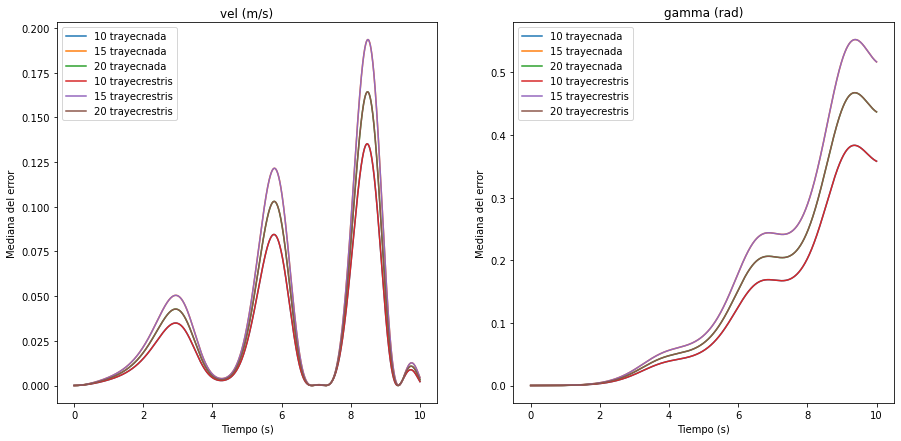

In [33]:
# Representar
plot_error_vs_tiempo(t, errors3, n_trayectorias_test, labs=['nada', 'restris'])

In [34]:
#tiempos de validacion mas largos:

labs=['nada', 'initial_guess', 'restris', 'completo']

n_trayectorias_test = [10]
tiempos_val = [10, 50, 100, 500, 1000]
n_sims = N_SIMS
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = 0.0001

# t_val = np.arange(0, int(n*3*deltat), deltat)
# t_val2 = np.arange(0, int(n*3*deltat_train), deltat_train)

constraint_lhs, constraint_rhs = restri()
models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1),
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            lib=utils.custom_ecs_D1(), opt=1), 
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1)]
errors4 = []
error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2)) #escalado en el tiempo

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2)) #escalado en el tiempo
    for i in range(len(n_trayectorias_test)):
        for z in range(len(tiempos_val)):
            t_val = np.arange(0, tiempos_val[z], deltat)
            t_val2 = np.arange(0, tiempos_val[z]/10, deltat_train)
            for j in range(n_sims):
                mod_class = utils.Model()
                mod_class.eval(utils.casoD1, n_trayectorias_test[i], t,
                                            [A3, A4, cd0, k], x0, 
                                            adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
                error[j,i, z, :] = mod_class.error_trayec(t_val2).mean(axis=0)
         
    errors4.append(error)


(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']


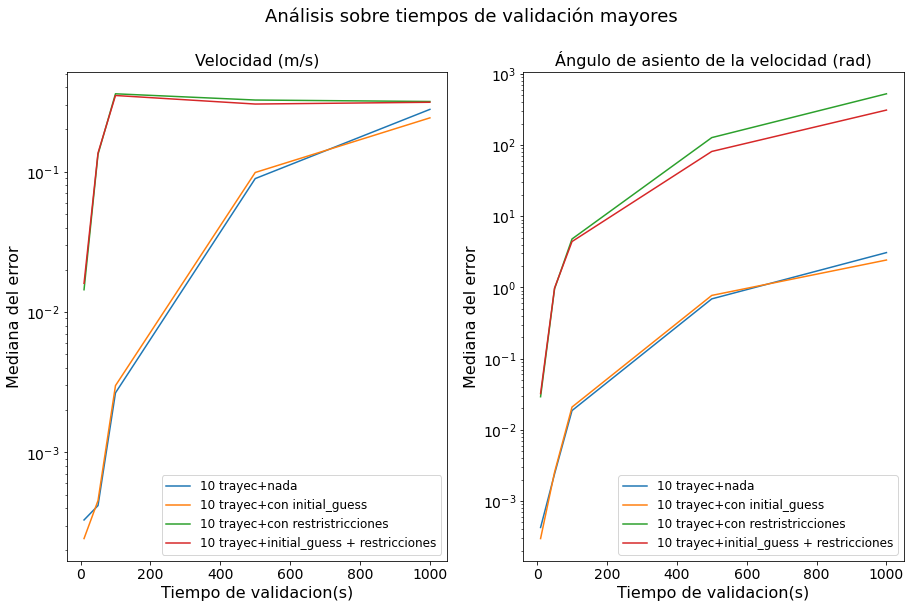

In [37]:
plot_error_vs_tiempo_val(tiempos_val, errors4, n_trayectorias_test)

In [28]:
# pruebo con otras librerías: polinomica

labs=['nada', 'initial_guess']
lib = ps.PolynomialLibrary(degree=3)
n_trayectorias_test = [2, 10, 15, 20]
n_sims = N_SIMS*2
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = 0.0001
t_val = np.arange(0, int(n*deltat_train), deltat_train)

#assert n2 == len_traj

models = [None, ]
            #utils.Model_params(deltat=deltat_train, initial_guess=initial(lib=lib), lib=lib, opt=1)]
errors_pol = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2)) #escalado en el tiempo

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test), t.shape[0], 2)) #escalado en el tiempo
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, n_trayectorias_test[i], t,
                                        [A3, A4, cd0, k], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
         
    errors_pol.append(error)

(10, 4, 10000, 2)
(10, 4, 10000, 2)


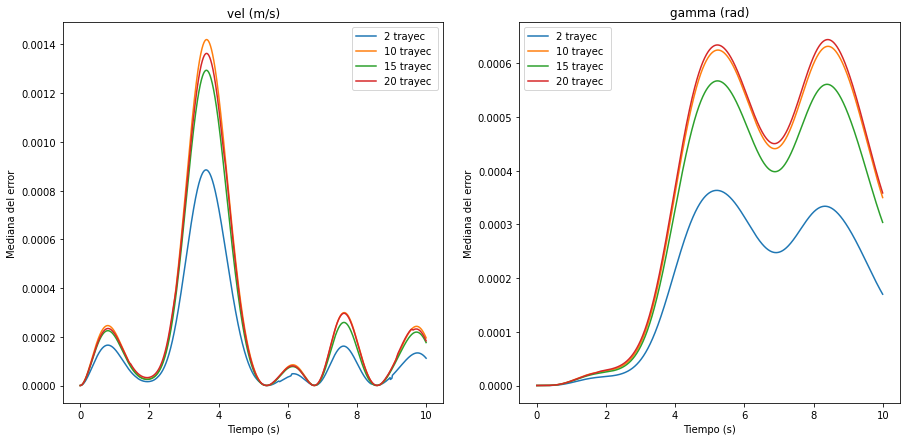

In [29]:
plot_error_vs_tiempo(t, errors_pol, n_trayectorias_test, labs=[' '])

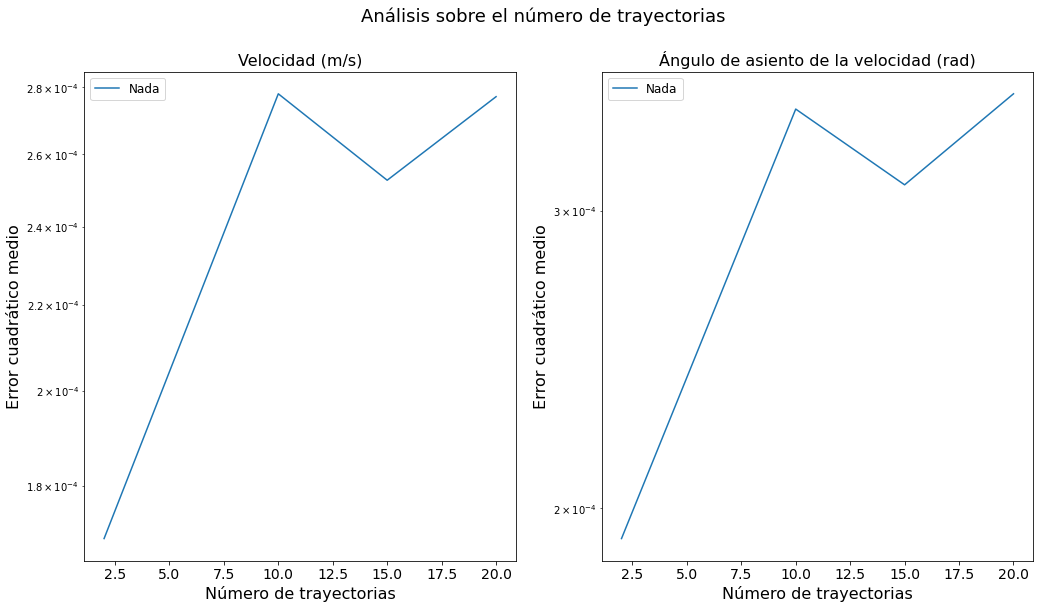

In [30]:
plot_ntraj(n_trayectorias_test, errors_pol) 

In [31]:
# pruebo con otras librerías: fourier
labs=['nada', 'initial_guess']
lib = ps.FourierLibrary(n_frequencies=2)
n_trayectorias_test = [2, 10, 15, 20]
n_sims = N_SIMS*2
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = 0.0001
n2 = 10**6
t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]

models = [None, ]
            #utils.Model_params(deltat=deltat_train, initial_guess=initial(lib=lib), lib=lib, opt=1)]
errors_fou = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2)) #escalado en el tiempo

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2)) #escalado en el tiempo
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, n_trayectorias_test[i], t,
                                        [A3, A4, cd0, k], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
         
    errors_fou.append(error)

nada


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


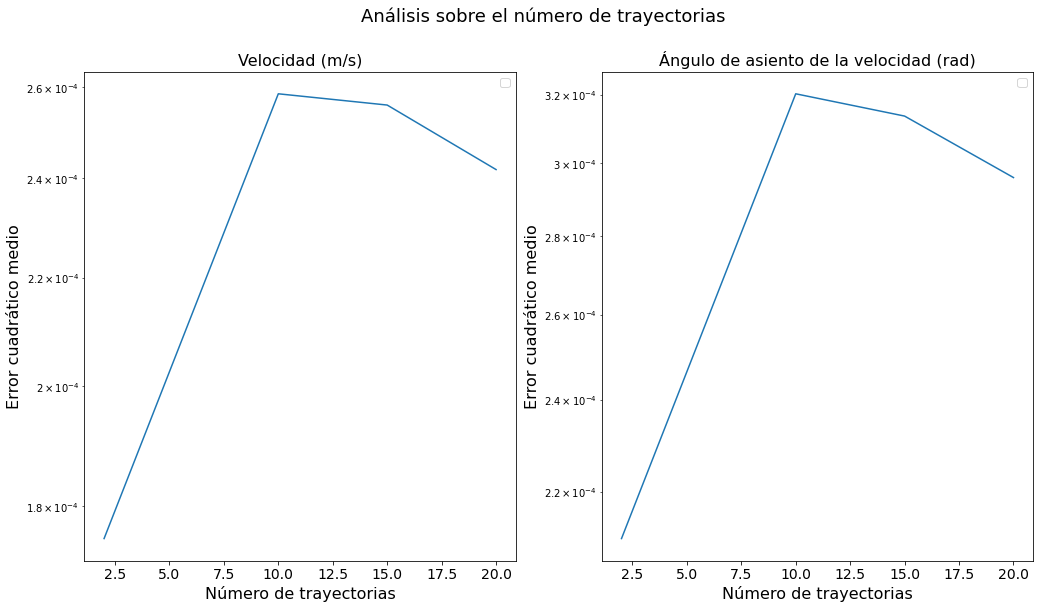

In [32]:
plot_ntraj(n_trayectorias_test, errors_fou, labs=['']) #escalado de tiempo

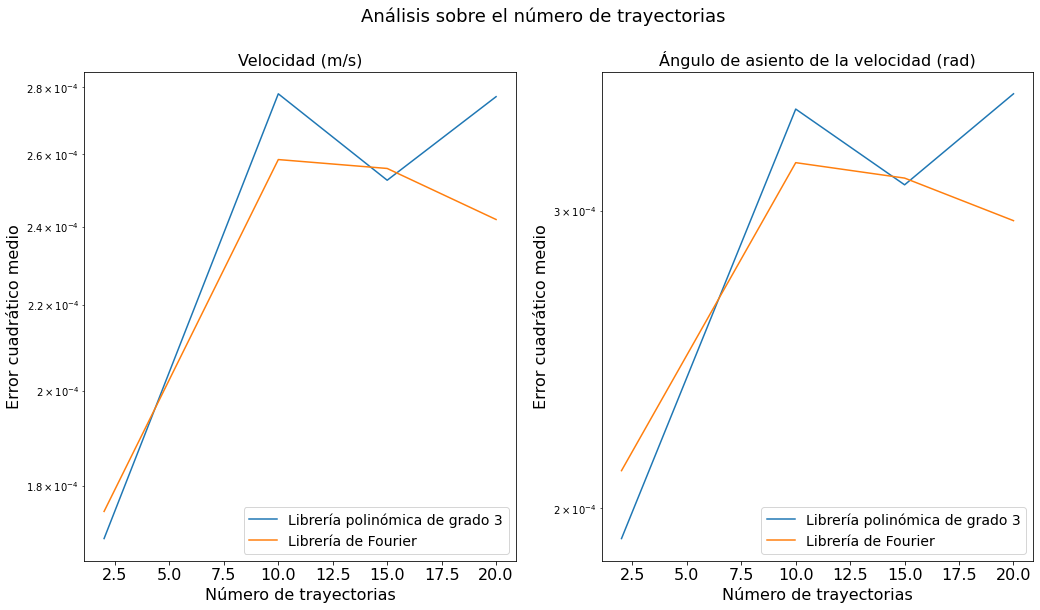

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(17, 9))
fig.suptitle("Análisis sobre el número de trayectorias", fontsize=18)
errors_mean = []
errors_mean2 = []
for err1, err2 in zip(errors_pol, errors_fou):    
    errors_mean.append(np.mean(err1, axis=2))
    errors_mean2.append(np.mean(err2, axis=2))

name = ['Velocidad (m/s)', 'Ángulo de asiento de la velocidad (rad)']
labs = ['Librería polinómica de grado 3', 'Librería de Fourier']
for j in range(len(errors_mean)):
    for i in range(errors_mean[j].shape[-1]): 
        axs[i].set_title(name[i], fontsize=16)
        axs[i].semilogy(n_trayectorias_test, np.median(errors_mean[j][:, :, i], axis=0), label=labs[j])
        axs[i].semilogy(n_trayectorias_test, np.median(errors_mean2[j][:, :, i], axis=0), label=labs[j+1])
        axs[i].set_xlabel('Número de trayectorias', fontsize=16)
        axs[i].set_ylabel('Error cuadrático medio', fontsize=16)
        axs[i].legend(fontsize=14)
        axs[i].tick_params(axis='both', labelsize=16)
    

In [42]:
# pruebo con otras librerías: polinomica + fourier
labs=['nada', 'initial_guess']
lib = ps.PolynomialLibrary(degree=2) + ps.FourierLibrary(n_frequencies=2)
n_trayectorias_test = [2, 10, 15, 20]
n_sims = N_SIMS
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = 0.0001
n2 = 10**6
t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]
#assert n2 == len_traj

models = [None, ] 
            #utils.Model_params(deltat=deltat_train, initial_guess=initial(lib=lib), lib=lib, opt=1)]
errors_pf = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2)) #escalado en el tiempo

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2)) #escalado en el tiempo
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, n_trayectorias_test[i], t, 
                                        [A3, A4, cd0, k], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
         
    errors_pf.append(error)

nada


(5, 4, 10000, 2)
(5, 4, 10000, 2)


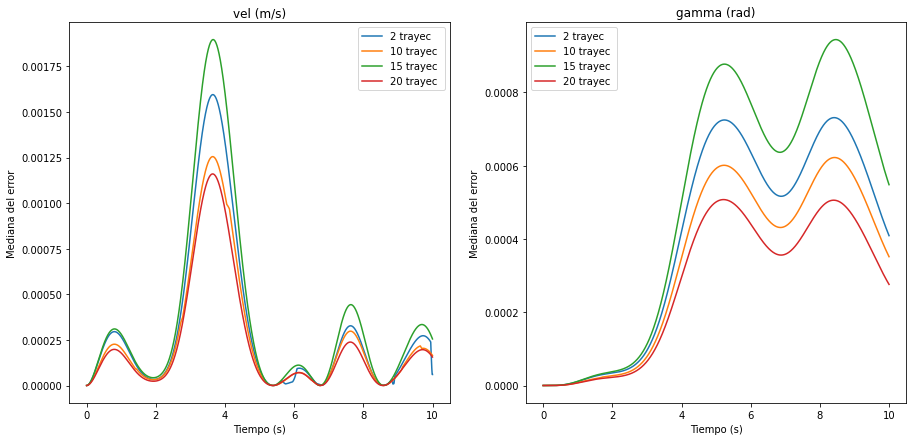

In [43]:
plot_error_vs_tiempo(t, errors_pf, n_trayectorias_test, labs=[' '])

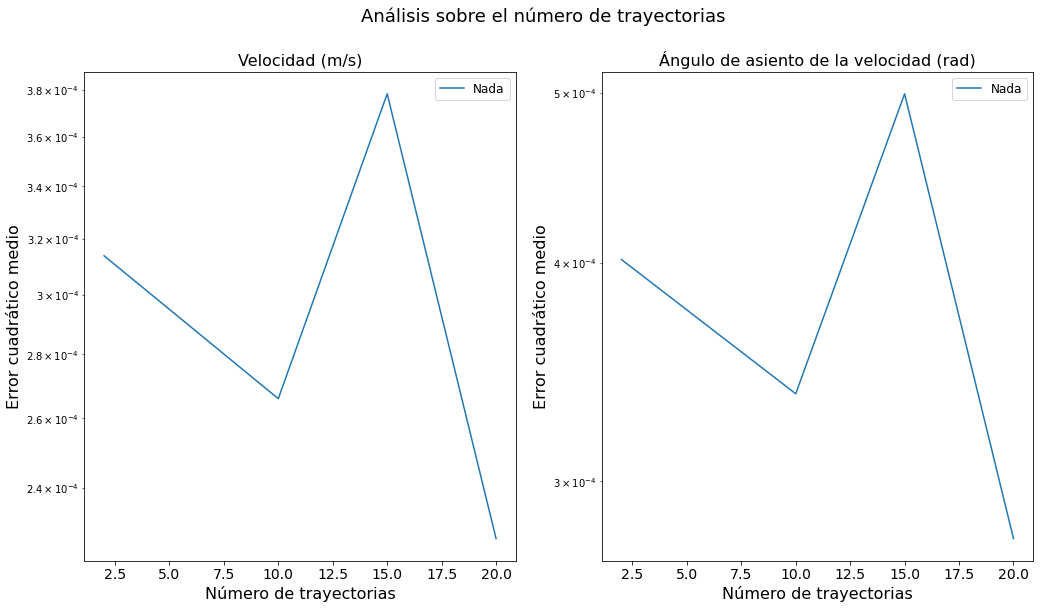

In [44]:
plot_ntraj(n_trayectorias_test, errors_pf) #escalado de tiempo

In [12]:
# obtengo el error con ruido en las muestras
labs=['nada', 'initial_guess', 'restris', 'completo']

n_trayectorias_test = [2, 10, 15, 20]
tiempos_val = [10, 50, 100, 500, 1000]
n_sims = N_SIMS
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = 0.0001


constraint_lhs, constraint_rhs = restri()
models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1),
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            lib=utils.custom_ecs_D1(), opt=1), 
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1)]
errors5 = []
error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2)) #escalado en el tiempo

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2)) #escalado en el tiempo
    for i in range(len(n_trayectorias_test)):
        for z in range(len(tiempos_val)):
            t_val = np.arange(0, tiempos_val[z], deltat)
            t_val2 = np.arange(0, tiempos_val[z]/10, deltat_train)
            for j in range(n_sims):
                mod_class = utils.Model()
                mod_class.eval(utils.casoD1, n_trayectorias_test[i], t,
                                            [A3, A4, cd0, k], x0, ruido=0.01,
                                            adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
                error[j,i, z, :] = mod_class.error_trayec(t_val2).mean(axis=0)
         
    errors5.append(error)



(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
nada


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
plot_error_vs_tiempo_val(t, errors5, n_trayectorias_test)

In [27]:
# obtengo el error con ruido en las muestras
labs=['nada', 'initial_guess', 'restris', 'completo']

n_trayectorias_test = [2, 10, 15, 20]
tiempos_val = [10, 50, 100, 500, 1000]
n_sims = N_SIMS
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = 0.0001


constraint_lhs, constraint_rhs = restri()
models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1),
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            lib=utils.custom_ecs_D1(), opt=1), 
            utils.Model_params(deltat=deltat_train, constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs, 
            initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1)]
errors6 = []
error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2)) #escalado en el tiempo

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2)) #escalado en el tiempo
    for i in range(len(n_trayectorias_test)):
        for z in range(len(tiempos_val)):
            t_val = np.arange(0, tiempos_val[z], deltat)
            t_val2 = np.arange(0, tiempos_val[z]/10, deltat_train)
            for j in range(n_sims):
                mod_class = utils.Model()
                mod_class.eval(utils.casoD1, n_trayectorias_test[i], t,
                                            [A3, A4, cd0, k], x0, ruido=0.0003,
                                            adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
                error[j,i, z, :] = mod_class.error_trayec(t_val2).mean(axis=0)
         
    errors6.append(error)

(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
nada
(10000, 2)
(10000, 2)


/home/mdiaz/TFGAero/utils.py:283: RuntimeWarning: overflow encountered in square
  data_dot = []
/home/mdiaz/TFGAero/utils.py:286: RuntimeWarning: overflow encountered in square
  v0 = np.random.uniform(low=5, high=15)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
plot_error_vs_tiempo_val(t, errors6, n_trayectorias_test)

In [13]:
# error vs potencia de ruido en las muestras sin aplicar restricciones ni initial_guess

n_trayectorias_test = [5, 10, 15]
n_sims = N_SIMS
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
pots_ruido = [1e-4, 1e-3, 1e-2, 0.1]
deltat_train = 0.0001
# t_train vs error en cada punto
error7 = np.zeros((n_sims, len(n_trayectorias_test), len(pots_ruido), 2))
t_val = np.arange(0, int(n*deltat_train), deltat_train)
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, n_trayectorias_test[i], 
                                            t, [A3, A4, cd0, k], x0,
                                            adim=False, deltat_train=deltat_train, ruido=pots_ruido[z])
            error7[j,i,z, :] = mod_class.error_trayec(t_val).mean(axis=0)
            print(pots_ruido[z])


/home/mdiaz/TFGAero/utils.py:334: RuntimeWarning: overflow encountered in square
  lambda v : v**2,
/home/mdiaz/TFGAero/utils.py:337: RuntimeWarning: overflow encountered in square
  lambda v, theta: np.cos(theta)**2/v**2,


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Representar pot ruido vs error con ruido
plot_error_vs_pot_ruido(error7, n_trayectorias_test, pots_ruido)

In [29]:
# representar precision vs t de train y error medio BORRAR EN ESTE CASO?
#n_trayectorias_test = [5, 10, 15]
trayec=10
n_sims = 10
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
tiempos_train = [10, 50, 100, 500, 1000]
muestras = [10**4, 10**5, 10**6]
deltat_train = 0.0001
# t_train vs error en cada punto
error8 = np.zeros((n_sims, len(muestras), len(tiempos_train), 2))
for i in range(len(muestras)):
    for j in range(n_sims):
        for z in range(len(tiempos_train)):
            t_train = np.arange(0, tiempos_train[z], deltat)
            #t_val = np.arange(0, tiempos_val[z], deltat)
            t_val2 = np.arange(0, tiempos_train[z]/10, deltat_train)
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, trayec, 
                                            t_train, [A3, A4, cd0, k], x0,
                                            adim=False, deltat_train=deltat_train)
            error8[j,i,z] = mod_class.error_trayec(t_val2).mean(axis=0)
            


<ipython-input-56-38bcd36a68c2>:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


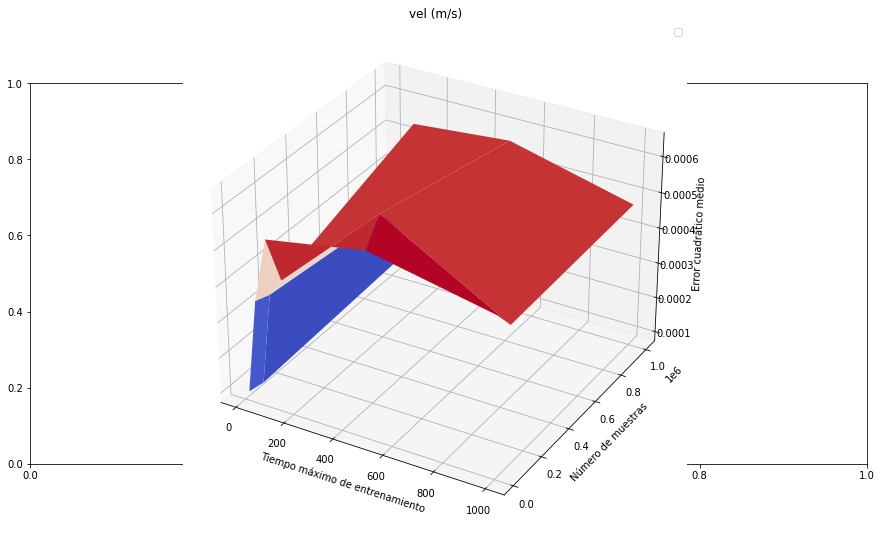

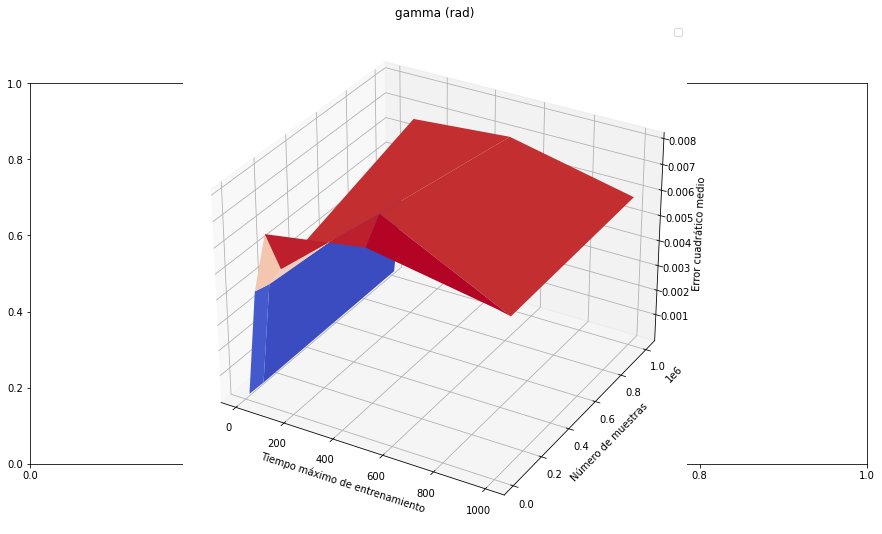

In [75]:
plot_precision_tiempo(error8, muestras, tiempos_train)

In [24]:
def real_coefs_mat(real_coefs):
    features, data, list_names = initial_vars()
    mat = np.zeros((data[0].shape[1], features))

    mat[0, list_names.index('1v')] = real_coefs[4]
    mat[0, list_names.index('v^2')] = real_coefs[0]
    mat[0, list_names.index('cos(gamma)^2/v^2')] = real_coefs[3]
    mat[0, list_names.index('cos(gamma)')] = real_coefs[2]
    mat[0, list_names.index('sin(gamma)')] = real_coefs[1]
    mat[1, list_names.index('v')] = real_coefs[5]

    return mat

In [25]:
def error_coefs(real_coefs, sim_coefs):
    sim_coefs[0, -2] = sim_coefs[0, -2] + sim_coefs[0, -1]
    sim_coefs[0, -1] = 0

    return np.mean((real_coefs -  sim_coefs)**2)

In [26]:
# error en los coeficientes según el número de trayectorias con escalado de tiempo:
n_trayectorias_test = [5, 10, 15, 20]
n_sims = 20
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = 0.0001
n2 = 10**6
t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]

rel = deltat/deltat_train
real_coefs = np.array([-A5*rel, -A7*rel, -A6*rel, -A8*rel, A3*rel, A4*rel])
mat_real_coefs = real_coefs_mat(real_coefs)

constraint_lhs, constraint_rhs = restri()
models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1)]
errors9 = []
errors9_1 = []
error = np.zeros((n_sims, len(n_trayectorias_test))) #escalado en el tiempo

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test))) #escalado en el tiempo
    error2 = np.zeros((n_sims, len(n_trayectorias_test))) #escalado en el tiempo
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, n_trayectorias_test[i], t,
                                        [A3, A4, cd0, k], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod, print_model=False)
            error[j, i] = error_coefs(mat_real_coefs, mod_class.model_sindy.coefficients())
            error2[j, i] = mod_class.error_trayec(t_val).mean(axis=0).mean()
         
    errors9.append(error)
    errors9_1.append(error2)


(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']


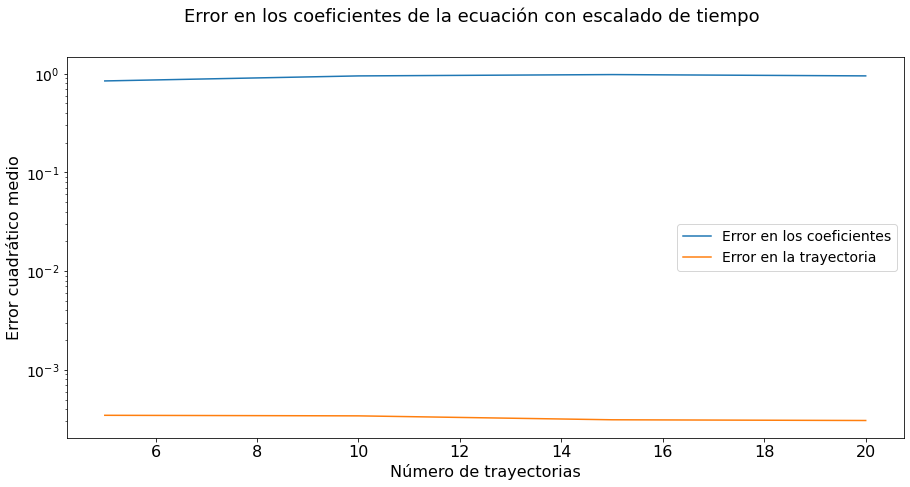

In [27]:

fig= plt.figure(figsize=(15, 7))
fig.suptitle('Error en los coeficientes de la ecuación con escalado de tiempo', fontsize=18)
#labs = ['nada', 'initial_guess']
errors9_2 = errors9.copy()
""" errors9_2[0] = errors9_2[1]"""
del errors9_2[1] 
for j, err in enumerate(errors9_2):
    plt.semilogy(n_trayectorias_test[:], np.median(err[:], axis=0), label='Error en los coeficientes')
    plt.semilogy(n_trayectorias_test[:], np.median(errors9_1[j], axis=0), label='Error en la trayectoria')
    plt.xlabel('Número de trayectorias', fontsize=16)
    plt.ylabel('Error cuadrático medio', fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=14)

In [28]:
# error en los coeficientes según el número de trayectorias sin escalado de tiempo:
n_trayectorias_test = [5, 10, 15, 20]
n_sims = 20
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]
n2 = 10**6
t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]

rel = deltat/deltat_train
real_coefs = np.array([-A5, -A7, -A6, -A8, A3, A4])
mat_real_coefs = real_coefs_mat(real_coefs)

constraint_lhs, constraint_rhs = restri()
models = [None]#, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D1(), opt=1)]
errors10 = []
errors10_1 = []
error = np.zeros((n_sims, len(n_trayectorias_test))) 

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test))) 
    error2 = np.zeros((n_sims, len(n_trayectorias_test))) 
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD1, n_trayectorias_test[i], t,
                                        [A3, A4, cd0, k], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod, print_model=False)
            error[j, i] = error_coefs(mat_real_coefs, mod_class.model_sindy.coefficients())
            error2[j, i] = mod_class.error_trayec(t).mean(axis=0).mean()
         
    errors10.append(error)
    errors10_1.append(error2)

(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
(10000, 2) (20000, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']


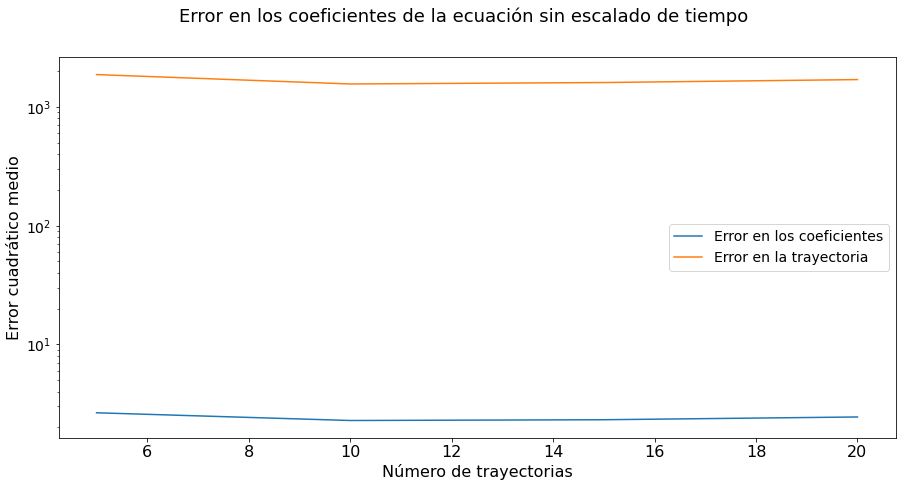

In [29]:
fig= plt.figure(figsize=(15, 7))
fig.suptitle('Error en los coeficientes de la ecuación sin escalado de tiempo', fontsize=18)
labs = ['nada', 'initial_guess']
errors10_2 = errors10.copy()
""" errors9_2[0] = errors9_2[1]
del errors9_2[1] """
for j, err in enumerate(errors10_2):
    plt.semilogy(n_trayectorias_test[:], np.median(err[:], axis=0), label='Error en los coeficientes')
    plt.semilogy(n_trayectorias_test[:], np.median(errors10_1[j], axis=0), label='Error en la trayectoria')
    plt.xlabel('Número de trayectorias', fontsize=16)
    plt.ylabel('Error cuadrático medio', fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=14)

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
        1.e+03, 1.e+04, 1.e+05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

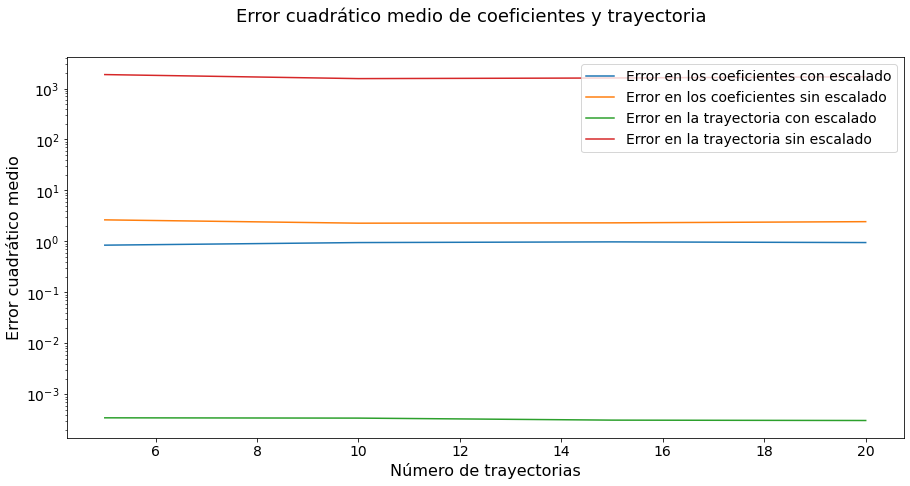

In [30]:
fig= plt.figure(figsize=(15, 7))
fig.suptitle('Error cuadrático medio de coeficientes y trayectoria', fontsize=18)
labs = ['Con escalado de tiempo', 'Sin escalado de tiempo']
#for j, err in enumerate(errors10):

plt.semilogy(n_trayectorias_test, np.median(errors9[0], axis=0), label='Error en los coeficientes con escalado')
plt.semilogy(n_trayectorias_test, np.median(errors10[0], axis=0), label='Error en los coeficientes sin escalado')
plt.semilogy(n_trayectorias_test, np.median(errors9_1[0], axis=0), label='Error en la trayectoria con escalado')
plt.semilogy(n_trayectorias_test, np.median(errors10_1[0], axis=0), label='Error en la trayectoria sin escalado')
plt.xlabel('Número de trayectorias', fontsize=16)
plt.ylabel('Error cuadrático medio', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

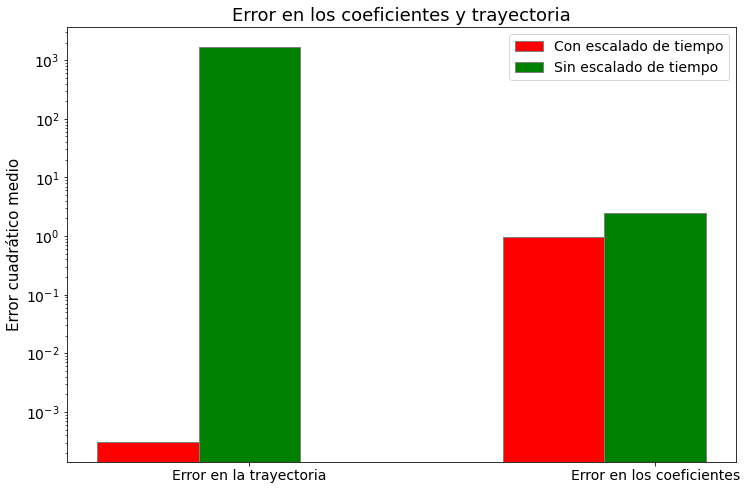

In [63]:
# hacer un histograma eje y con el error y en x con la leyenda error en trayec y error en coefs
""" fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Sin escalado de tiempo', 'Con escalado de tiempo']
students = [23,17,35,29,12]
ax.bar(langs,students)
plt.show() """

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(2)
br2 = [x + barWidth for x in br1]
# br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, [np.median(errors9_1[0], axis=0)[-1], np.median(errors9[0], axis=0)[-1]], 
                color ='r', width = barWidth,
        edgecolor ='grey', label ='Con escalado de tiempo')
plt.bar(br2, [np.median(errors10_1[0], axis=0)[-1], np.median(errors10[0], axis=0)[-1]], color ='g', width = barWidth,
        edgecolor ='grey', label ='Sin escalado de tiempo')
 
# Adding Xticks
#plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
plt.title('Error en los coeficientes y trayectoria', fontsize=18)
plt.ylabel('Error cuadrático medio', fontsize = 15)
plt.xticks([r + barWidth for r in range(2)],
        ['Error en la trayectoria', 'Error en los coeficientes'], fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(fontsize = 14)
plt.show()



In [47]:
[np.median(errors9_1[0], axis=0)[-1], np.median(errors10_1[0], axis=0)[-1]]

[0.0003064991460834183, 1702.1080916704716]

In [51]:
[np.median(errors9[0], axis=0)[-1], np.median(errors10[0], axis=0)[-1]]

[0.9497929714954851, 2.440783950344607]